In [1]:
#data analysis of the predictions
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
from statsmodels.regression.linear_model import OLS
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
import datetime
from sklearn.metrics import roc_auc_score
%matplotlib inline

In [2]:
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [3]:
alldata_processed =\
    pd.read_csv("data/annotations/alldata_processed_with_dev_residual.csv" )
alldata_processed['videoid'] = alldata_processed['videoid'].apply(lambda x: int(x))
alldata_processed['Event_Date'] = pd.to_datetime(alldata_processed['Event_Date'],format='%Y-%m-%d')

In [4]:
def add_predictions(df,target_col):
    predictions = pd.read_csv("./predictions/cnn_%s_predictions_best_epoch.csv" % (target_col),dtype={'videoid':int})
    predictions = predictions[['videoid','side','%s_pred_corrected' % (target_col)]]
    df = df.merge(right=predictions,on=['videoid','side'],how='left')
    return df

In [26]:
df = alldata_processed.copy()
df = add_predictions(df,"SEMLS_dev_residual")
df = add_predictions(df,"GDI")

In [27]:
df['Anteversion'].fillna(np.mean(df['Anteversion']),inplace=True)

In [28]:
df['SEMLS_dev_residual_pred_corrected_buckets'] =\
    np.clip(np.floor(df['SEMLS_dev_residual_pred_corrected']/0.1)*0.1,-0.6,0.2)

Text(0.5,1,u'mean(SEMLS) vs CNN predicted SEMLS dev residual: test set')

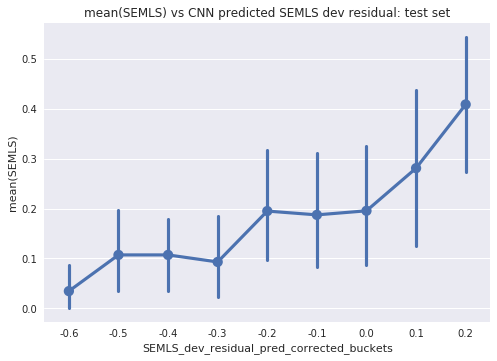

In [29]:
sns.pointplot(x='SEMLS_dev_residual_pred_corrected_buckets',y='SEMLS',data=df[df['dataset'] == 'test'])
plt.title("mean(SEMLS) vs CNN predicted SEMLS dev residual: test set")

In [30]:
Xcols = ["mass_interpolated","mass_interpolated2","age_truncated2","age_truncated",
         "height_interpolated","height_interpolated2",
         'SEMLS_dev_residual_pred_corrected',"isPostSurgGaitVisit","const"]

X_train = df[df['dataset'] == 'train'][Xcols]
y_train = df[df['dataset'] == 'train']["SEMLS"]
X = df[Xcols]
y = df["SEMLS"]

lm = Logit(y_train,X_train).fit()

df['predicted_SEMLS'] = lm.predict(X)

Optimization terminated successfully.
         Current function value: 0.389973
         Iterations 7


In [31]:
df['predicted_SEMLS_buckets'] =\
    np.clip(np.floor(df['predicted_SEMLS']/0.05)*0.05,0.05,0.4)

In [32]:
print(roc_auc_score(df[df['dataset'] == 'train']['SEMLS'],
              df[df['dataset'] == 'train']['predicted_SEMLS']),"train ROC")

print(roc_auc_score(df[df['dataset'] == 'validation']['SEMLS'],
              df[df['dataset'] == 'validation']['predicted_SEMLS']),"validation ROC")

print(roc_auc_score(df[df['dataset'] == 'test']['SEMLS'],
              df[df['dataset'] == 'test']['predicted_SEMLS']),"test ROC")


(0.74380277743036738, 'train ROC')
(0.72181987000928505, 'validation ROC')
(0.71631488648605512, 'test ROC')


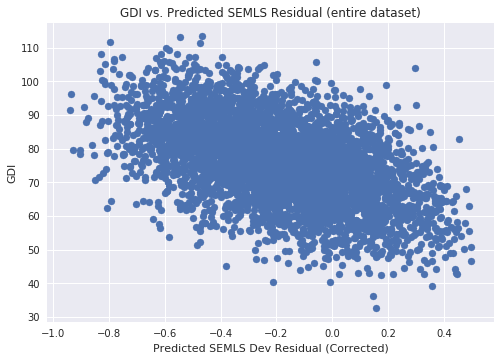

In [33]:
plt.scatter(df['SEMLS_dev_residual_pred_corrected'],df['GDI'])
plt.xlabel("Predicted SEMLS Dev Residual (Corrected)")
plt.ylabel("GDI")
plt.title("GDI vs. Predicted SEMLS Residual (entire dataset)");

In [34]:
from sklearn.metrics import roc_curve

In [35]:
fpr, tpr, thresholds = roc_curve(df[df['dataset'] == 'test']['SEMLS'],
          df[df['dataset'] == 'test']['predicted_SEMLS'])

Text(0,0.5,u'tpr')

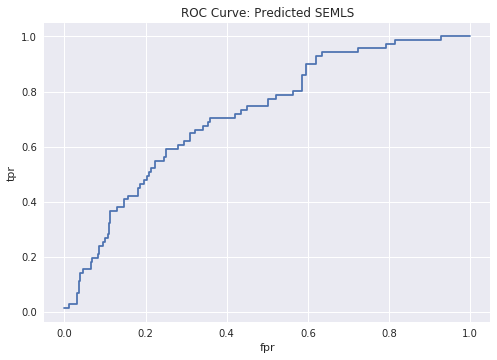

In [36]:
plt.plot(fpr,tpr)
plt.title("ROC Curve: Predicted SEMLS")
plt.xlabel("fpr")
plt.ylabel("tpr")

In [37]:
#same analysis but using gdi instead of cnn predictions
Xcols = ["mass_interpolated","mass_interpolated2","age_truncated2","age_truncated",
         "height_interpolated","height_interpolated2",
         'GDI',"isPostSurgGaitVisit","const"]

X_train = df[df['dataset'] == 'train'][Xcols]
y_train = df[df['dataset'] == 'train']["SEMLS"]
X = df[Xcols]
y = df["SEMLS"]

lm = Logit(y_train,X_train).fit()

df['predicted_SEMLS'] = lm.predict(X)
lm.summary2()

Optimization terminated successfully.
         Current function value: 0.406605
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
======================================================================
Model:                 Logit             Pseudo R-squared:  0.082     
Dependent Variable:    SEMLS             AIC:               2917.9092 
Date:                  2018-10-02 18:51  BIC:               2973.5220 
No. Observations:      3566              Log-Likelihood:    -1450.0   
Df Model:              8                 LL-Null:           -1580.1   
Df Residuals:          3557              LLR p-value:       1.0858e-51
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        7.0000                                         
----------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025   0.975]
----------------------------------------------------------------------
mass_interpolated    -0.0515   0.0193  -2.6636 0.0077  -0.0894 -0.0136
mass_interpolated2    0.0278   0.0169   1.6466 0.0996  -0.0053  0.0609
age_truncated2       -1.2783   0.4213  -3.0344 0.0024  -2.1040 -0.4526
age_truncated         0.2422   0.1181   2.0505 0.0403   0.0107  0.4737
height_interpolated   0.1049   0.0452   2.3200 0.0203   0.0163  0.1935
height_interpolated2 -0.0287   0.0152  -1.8875 0.0591  -0.0586  0.0011
GDI                  -0.0588   0.0044 -13.4406 0.0000  -0.0674 -0.0503
isPostSurgGaitVisit  -0.2830   0.0958  -2.9552 0.0031  -0.4708 -0.0953
const                -5.4986   2.6946  -2.0406 0.0413 -10.7799 -0.2173
======================================================================

"""

In [38]:
print(roc_auc_score(df[df['dataset'] == 'train']['SEMLS'],
              df[df['dataset'] == 'train']['predicted_SEMLS']),"train ROC")

print(roc_auc_score(df[df['dataset'] == 'validation']['SEMLS'],
              df[df['dataset'] == 'validation']['predicted_SEMLS']),"validation ROC")

print(roc_auc_score(df[df['dataset'] == 'test']['SEMLS'],
              df[df['dataset'] == 'test']['predicted_SEMLS']),"test ROC")


(0.70464036075096237, 'train ROC')
(0.692961931290622, 'validation ROC')
(0.68395642979691174, 'test ROC')


In [39]:
#including both variables
Xcols = ["mass_interpolated","mass_interpolated2","age_truncated2","age_truncated",
         "height_interpolated","height_interpolated2","SEMLS_dev_residual_pred_corrected",
         'GDI', "isPostSurgGaitVisit","const"]

X_train = df[df['dataset'] == 'train'][Xcols]
y_train = df[df['dataset'] == 'train']["SEMLS"]
X = df[Xcols]
y = df["SEMLS"]

lm = Logit(y_train,X_train).fit()

df['predicted_SEMLS'] = lm.predict(X)
lm.summary2()

Optimization terminated successfully.
         Current function value: 0.385454
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                  Results: Logit
==================================================================================
Model:                     Logit                 Pseudo R-squared:      0.130     
Dependent Variable:        SEMLS                 AIC:                   2769.0582 
Date:                      2018-10-02 18:51      BIC:                   2830.8502 
No. Observations:          3566                  Log-Likelihood:        -1374.5   
Df Model:                  9                     LL-Null:               -1580.1   
Df Residuals:              3556                  LLR p-value:           5.5042e-83
Converged:                 1.0000                Scale:                 1.0000    
No. Iterations:            7.0000                                                 
----------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z|   [0.025   0.975]
----------------------------------------------------------------------------------
mass_interpolated                 -0.0391   0.0203 -1.9216 0.0547  -0.0790  0.0008
mass_interpolated2                 0.0228   0.0178  1.2759 0.2020  -0.0122  0.0577
age_truncated2                    -1.0985   0.4263 -2.5766 0.0100  -1.9341 -0.2629
age_truncated                      0.1733   0.1203  1.4409 0.1496  -0.0624  0.4091
height_interpolated                0.1246   0.0473  2.6361 0.0084   0.0319  0.2172
height_interpolated2              -0.0373   0.0159 -2.3380 0.0194  -0.0685 -0.0060
SEMLS_dev_residual_pred_corrected  2.7265   0.2320 11.7531 0.0000   2.2718  3.1812
GDI                               -0.0283   0.0050 -5.6166 0.0000  -0.0382 -0.0184
isPostSurgGaitVisit               -0.2954   0.0984 -3.0011 0.0027  -0.4883 -0.1025
const                             -8.3272   2.8282 -2.9444 0.0032 -13.8703 -2.7841
==================================================================================

"""

In [40]:
print(roc_auc_score(df[df['dataset'] == 'train']['SEMLS'],
              df[df['dataset'] == 'train']['predicted_SEMLS']),"train ROC")

print(roc_auc_score(df[df['dataset'] == 'validation']['SEMLS'],
              df[df['dataset'] == 'validation']['predicted_SEMLS']),"validation ROC")

print(roc_auc_score(df[df['dataset'] == 'test']['SEMLS'],
              df[df['dataset'] == 'test']['predicted_SEMLS']),"test ROC")


(0.75339188356656162, 'train ROC')
(0.72869080779944295, 'validation ROC')
(0.72808522523241437, 'test ROC')


Run the linear model on just the test dataset to get confidence intervals.

I use cluster robust standard errors clustered by the videoid (since for each video there is GDI_L, GDI_R and there's likely some within video correlation)

In [41]:
Xcols = ["mass_interpolated","mass_interpolated2","age_truncated2","age_truncated",
         "height_interpolated","height_interpolated2",
         'GDI', "isPostSurgGaitVisit","SEMLS_dev_residual_pred_corrected","const"]

X_train = df[df['dataset'] == 'test'][Xcols]
y_train = df[df['dataset'] == 'test']["SEMLS"]
X = df[Xcols]
y = df["SEMLS"]

lm = Logit(y_train,X_train).fit(cov_type='cluster',cov_kwds={'groups':df[df['dataset'] == 'test']['videoid']})
lm.summary2()

Optimization terminated successfully.
         Current function value: 0.398748
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                  Results: Logit
==================================================================================
Model:                     Logit                 Pseudo R-squared:      0.117     
Dependent Variable:        SEMLS                 AIC:                   358.1384  
Date:                      2018-10-02 18:51      BIC:                   398.6358  
No. Observations:          424                   Log-Likelihood:        -169.07   
Df Model:                  9                     LL-Null:               -191.57   
Df Residuals:              414                   LLR p-value:           9.1930e-07
Converged:                 1.0000                Scale:                 1.0000    
No. Iterations:            8.0000                                                 
----------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z|   [0.025   0.975]
----------------------------------------------------------------------------------
mass_interpolated                  0.0809   0.0861  0.9401 0.3472  -0.0878  0.2497
mass_interpolated2                -0.0962   0.0795 -1.2095 0.2265  -0.2520  0.0597
age_truncated2                    -1.7943   1.6842 -1.0654 0.2867  -5.0953  1.5067
age_truncated                      0.4842   0.4909  0.9862 0.3240  -0.4780  1.4464
height_interpolated               -0.1107   0.1916 -0.5776 0.5636  -0.4862  0.2649
height_interpolated2               0.0313   0.0620  0.5059 0.6129  -0.0901  0.1528
GDI                               -0.0299   0.0160 -1.8657 0.0621  -0.0614  0.0015
isPostSurgGaitVisit               -0.2153   0.3814 -0.5645 0.5724  -0.9628  0.5322
SEMLS_dev_residual_pred_corrected  1.9783   0.7045  2.8082 0.0050   0.5976  3.3590
const                              5.7987  11.1851  0.5184 0.6042 -16.1238 27.7212
==================================================================================

"""

# Analyze GDI Predictions

In [61]:
alldata_subset = alldata_processed[['videoid','side','Event_Date','Patient_ID','GDI','gmfcs']].copy()
cnn_gdi_predictions = pd.read_csv("./predictions/cnn_GDI_predictions_best_epoch.csv",dtype={'videoid':str})
cnn_gdi_predictions['videoid'] = cnn_gdi_predictions['videoid'].apply(lambda x: int(x))
cnn_gdi_predictions = cnn_gdi_predictions.merge(right=alldata_subset,on=['videoid','side'],how='left')

In [62]:
sns.reset_defaults();

In [63]:
cnn_gdi_predictions[cnn_gdi_predictions['dataset'] == 'test'].corr()

,GDI_pred_corrected,videoid,Patient_ID,GDI,gmfcs
GDI_pred_corrected,1.000000,0.067510,0.299195,0.736157,-0.019627
videoid,0.067510,1.000000,0.597107,0.127925,0.194190
Patient_ID,0.299195,0.597107,1.000000,0.206814,0.156209
GDI,0.736157,0.127925,0.206814,1.000000,-0.011384
gmfcs,-0.019627,0.194190,0.156209,-0.011384,1.000000


Text(0.5,1,u'GDI Predictions: Test Set ($\\rho$ = 0.74)')

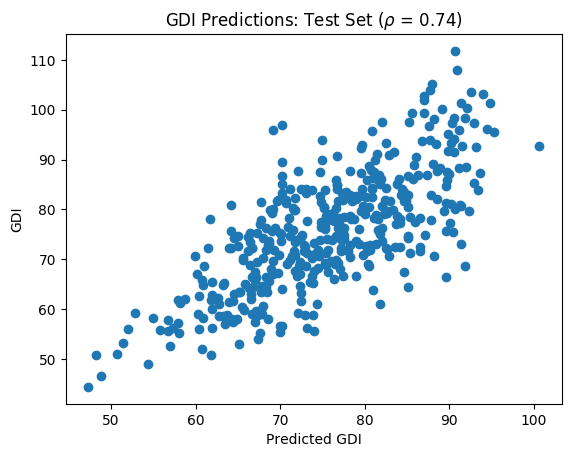

In [64]:
plt.scatter(cnn_gdi_predictions[cnn_gdi_predictions['dataset'] == 'test']['GDI_pred_corrected'],
            cnn_gdi_predictions[cnn_gdi_predictions['dataset'] == 'test']['GDI'])
plt.xlabel("Predicted GDI")
plt.ylabel("GDI")
plt.title("GDI Predictions: Test Set ($\\rho$ = 0.74)")
plt.savefig("./figures/gdi_scatterplot.png",dpi=600)

In [ ]:
#distribution of GDI in different GMFCS groups
sns.pointplot(x='gmfcs',y='GDI',data=cnn_gdi_predictions,color='green',
             label='GDI')
plt.ylabel("Average GDI")
plt.ylim([40,110]);
plt.title("GDI by GMFCS")
plt.legend()
plt.savefig("./figures/gmfcs_scatterplot.png",dpi=600)

In [59]:
analyze_changes = cnn_gdi_predictions.sort_values(by=["Patient_ID","side","Event_Date"]).copy()
analyze_changes = analyze_changes[analyze_changes['dataset'] == 'test'].groupby(["Patient_ID","side"])["GDI","GDI_pred_corrected"].diff(1)

Text(0.5,1,u'Change in Predicted GDI vs Change in GDI: Test Set (corr = 0.338291981688)')

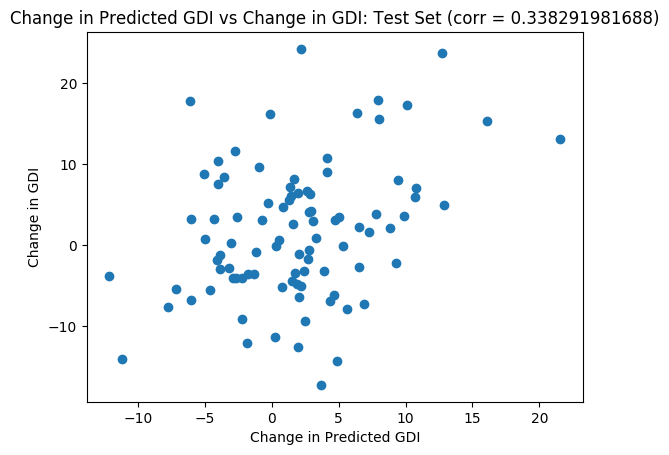

In [60]:
forplot = analyze_changes.copy()
corr = forplot.corr()['GDI_pred_corrected']['GDI']
plt.scatter(forplot['GDI_pred_corrected'],forplot['GDI'])
plt.xlabel("Change in Predicted GDI")
plt.ylabel("Change in GDI")
plt.title("Change in Predicted GDI vs Change in GDI: Test Set (corr = %s)" % (corr))

In [ ]:
#showing increase in correlation for changes >= ~RMSE
forplot = analyze_changes[np.abs(analyze_changes['GDI_pred_corrected']) >= 8].copy()
corr = forplot.corr()['GDI_pred_corrected']['GDI']
plt.scatter(forplot['GDI_pred_corrected'],forplot['GDI'])
plt.xlabel("Change in Predicted GDI")
plt.ylabel("Change in GDI")
plt.title("Change in Predicted GDI vs Change in GDI: Test Set (corr = %s)" % (corr))